In [15]:
import cv2
import numpy as np
import os
import sys
import tensorflow as tf
from datetime import datetime
from matplotlib import pyplot as plt

In [25]:
EPOCHS = 10
IMG_WIDTH = 256
IMG_HEIGHT = 196
NUM_CATEGORIES = 5
# TEST_SIZE = 0.4
GESTURE = {0:"ok", 1:"up", 2:"down", 3:"palm", 4:"l"}

In [18]:
def load_data(data_dir):
    """
    Load image data from directory `data_dir`.
    Assume `data_dir` has one directory named after each category, numbered
    0 through NUM_CATEGORIES - 1. Inside each category directory will be some
    number of image files.
    Return tuple `(images, labels)`. `images` should be a list of all
    of the images in the data directory, where each image is formatted as a
    numpy ndarray with dimensions IMG_WIDTH x IMG_HEIGHT x 3. `labels` should
    be a list of integer labels, representing the categories for each of the
    corresponding `images`.
    """
    images = []
    labels = []
    
    for dir in range(0, NUM_CATEGORIES):
        # get path for each gesture like "/home/arpine/Desktop/data/0":  
        d = os.path.join(data_dir, f"{str(dir)}")
        # os.listdir(d) return the list of all names of images in that folder
        for image_path in os.listdir(d):
            # get the full path of specific image 
            full_path = os.path.join(data_dir, f"{str(dir)}", image_path)
            # Returns an image that is loaded from the specified file
            image = cv2.imread(full_path, )
        #     print(image.shape)
        #     image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        #     print(image.shape)
            # cv2.imshow("im", image)
            # get dimension for each image
            dim = (IMG_WIDTH, IMG_HEIGHT)
            # resized the image
            image_resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
        #     print(image_resized.shape)
            
        #     add image and their directory name to images and labels list
            images.append(image_resized)
            labels.append(dir)
    # images = np.load(images)
    # labels = np.load(labels)

    
    return images, labels

In [26]:
start_time = datetime.now()  
print("Loading ===========") 
images_test, labels_test = load_data("/home/arpine/Desktop/Gesture/test") 
images_train, labels_train = load_data("/home/arpine/Desktop/Gesture/train") 
valid_image, valid_label  = load_data("/home/arpine/Desktop/Gesture/valid")

# images_test, labels_test = load_data("images_test.npy", "labels_test.npy") 
# images_train, labels_train = load_data("images_train.npy", "labels_train.npy" ) 
# valid_image, valid_label  = load_data("images_valid.npy", "labels_valid.npy" )
finish_loading_time = datetime.now()
print("Images load time: ", finish_loading_time - start_time)

Loading ===========
Images load time:  0:02:00.030331


In [27]:
def get_model():
    """
    Returns a compiled convolutional neural network model. Assume that the
    `input_shape` of the first layer is `(IMG_WIDTH, IMG_HEIGHT, 3)`.
    The output layer should have `NUM_CATEGORIES` units, one for each category.
    """
    # Create a convolutional neural network
    model = tf.keras.models.Sequential(
        [
        # Convolutional layer. Learn 32 filters using a 3x3 kernel
        tf.keras.layers.Conv2D(
            32, (5, 5), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
        ),
        # Max-pooling layer, using 2x2 pool size
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(
            64, (3, 3), activation='relu'#, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)
        ),
        # Max-pooling layer, using 2x2 pool size
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(
            128, (3, 3), activation='relu' #, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)
        ),
        # Max-pooling layer, using 2x2 pool size
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(
            256, (3, 3), activation='relu' #, input_shape=((IMG_WIDTH), (IMG_HEIGHT), 3)
        ),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(
            512, (3, 3), activation='relu' #, input_shape=((IMG_WIDTH), (IMG_HEIGHT), 3)
        ),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(
            1064, (3, 3), activation='relu'#, input_shape=((IMG_WIDTH), (IMG_HEIGHT), 3)
        ),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        
        tf.keras.layers.Flatten(),
        # Add a hidden layer with dropout
        tf.keras.layers.Dense(1064, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        # tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        # tf.keras.layers.Dropout(0.2),
        # tf.keras.layers.Dense(128, activation='relu'),
        # tf.keras.layers.Dropout(0.2),
        # tf.keras.layers.Dense(128, activation='relu'),
        # tf.keras.layers.Flatten(),
        # Add an output layer with output units for all 6 gestures
        # tf.keras.layers.Dense(NUM_CATEGORIES, activation='sigmoid')
        tf.keras.layers.Dense(NUM_CATEGORIES, activation='softmax')
    ])

  
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(
        optimizer=optimizer ,
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

      # Train neural network
    # model.compile(
    #     optimizer='adam',
    #     loss="categorical_crossentropy",
    #     metrics=["accuracy"]
    # )
    # return model

In [28]:
print("====================")
y_test = tf.keras.utils.to_categorical(labels_test)
y_train = tf.keras.utils.to_categorical(labels_train)
y_valid = tf.keras.utils.to_categorical(valid_label)

x_train = np.array(images_train)/255
# x_train = x_train.astype('float32')/255

x_test = np.array(images_test)/255
# x_test = x_test.astype('float64')/255
# # print(x_test)
x_valid = np.array(valid_image)/255
# x_valid = x_valid.astype('float64')/255
# X_train = np.array(images_train)
print(x_train.shape)
# X_test = np.array(images_test)
print(x_test.shape)
# X_valid = np.array(valid_image)
print(x_valid.shape)

# Cenetering the data
# X_train_mean = np.mean(X_train, axis = 0)
# X_train_cent = X_train - X_train_mean
# # Normalization
# X_train_std = np.std(X_train, axis = 0)
# X_train_norm = X_train_cent / X_train_std

# # Normalization test set
# X_test_norm = (X_test - X_train_mean) / X_train_std

# # Normalization valid set
# X_valid_norm = (X_valid - X_train_mean) / X_train_std


(2980, 196, 256, 3)
(500, 196, 256, 3)
(1010, 196, 256, 3)


In [29]:
print("====================")
# Get a compiled neural network
fitting_time = datetime.now()
model = get_model()

# Fit model on training data
history = model.fit(x_train, y_train, epochs=EPOCHS, validation_data = (x_valid, y_valid))
# model.fit(train_data, epochs= EPOCHS)
# Evaluate neural network performance
model.evaluate(x_test, y_test, verbose=2)
finish_loading_time = datetime.now()

print("NN fit time: ", datetime.now() - fitting_time)


Epoch 1/10
94/94 [==============================] - 14s 122ms/step - loss: 1.6104 - accuracy: 0.2124 - val_loss: 1.6081 - val_accuracy: 0.2485
Epoch 2/10
94/94 [==============================] - 10s 103ms/step - loss: 1.4541 - accuracy: 0.3591 - val_loss: 1.4775 - val_accuracy: 0.3020
Epoch 3/10
94/94 [==============================] - 10s 103ms/step - loss: 0.8279 - accuracy: 0.6621 - val_loss: 1.5690 - val_accuracy: 0.3980
Epoch 4/10
94/94 [==============================] - 10s 103ms/step - loss: 0.4895 - accuracy: 0.8057 - val_loss: 1.9232 - val_accuracy: 0.4337
Epoch 5/10
94/94 [==============================] - 10s 103ms/step - loss: 0.3137 - accuracy: 0.8782 - val_loss: 1.9507 - val_accuracy: 0.4465
Epoch 6/10
94/94 [==============================] - 10s 103ms/step - loss: 0.2300 - accuracy: 0.9077 - val_loss: 1.5504 - val_accuracy: 0.5069
Epoch 7/10
94/94 [==============================] - 10s 104ms/step - loss: 0.1770 - accuracy: 0.9315 - val_loss: 2.3798 - val_accuracy: 0.4723

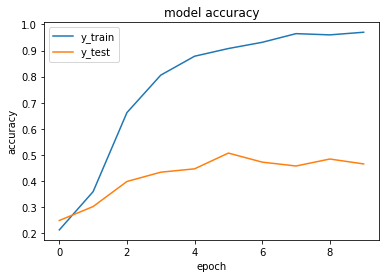

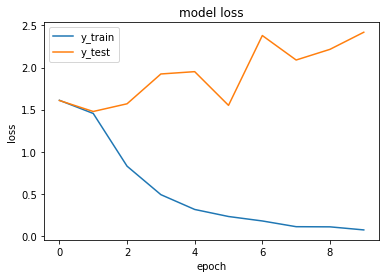

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['y_train', 'y_test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['y_train', 'y_test'], loc='upper left')
plt.show()

In [31]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 192, 252, 32)      2432      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 96, 126, 32)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 94, 124, 64)       18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 47, 62, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 45, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 22, 30, 128)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 20, 28, 256)      

In [32]:
video = cv2.VideoCapture(0)
    
while True:
        # Capture the video frame
        ret, img = video.read()

         # Display the resulting frame
        # to flip the video with 180 degree 
        image = cv2.flip(img, 1)
        #cv2.imshow('frame', image)
        
        # save image for prediction
        image = cv2.imwrite('Frame'+str(0)+'.jpg', image)
        image_addr = "Frame0.jpg"
        # image = cv2.imread(image_addr)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # cv2.imshow("gray", image)
        # handsModule = mediapipe.solutions.hands
        # with handsModule.Hands(static_image_mode=True) as hands:

        #         image = cv2.imread(image_addr)
        #         results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        #         image_height, image_width, _ = image.shape

        #         if results.multi_hand_landmarks:
        #                 for hand_landmark in results.multi_hand_landmarks:
        #                         x = [landmark.x for landmark in hand_landmark.landmark]
        #                         y = [landmark.y for landmark in hand_landmark.landmark]

        #                         center = np.array([np.mean(x)*image_width, np.mean(y)*image_height]).astype('int32')
        #                 #     cv2.imshow('video', image)
        #                         cv2.circle(image, tuple(center), 10, (255,0,0), 1) #for checking the center
        #                         cv2.rectangle(image, (center[0]-128,center[1]-128), (center[0]+128,center[1]+128), (255,0,0), 1)
        #                         hand = image[center[1]-128:center[1]+128, center[0]-128:center[0]+128]
        #                         # hand = cv2.resize(hand, dim, interpolation = cv2.INTER_AREA)
        #                 #     cv2.imshow('video', hand)
        #                         if hand.shape==(256, 256, 3):

        #                                 image_hand = cv2.imwrite(image_addr, hand)

        # rest, thresh = cv2.threshold(image, 70, 255, cv2.THRESH_BINARY)
        # _, contours = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        # image = cv2.imwrite(address, thresh)
        # image = cv2.imwrite('Frame'+str(0)+'.png', image)

        # image = "Frame0.png"
        # image = cv2.cvtColor(image_addr, cv2.COLOR_BGR2GRAY)
        dim = (IMG_WIDTH, IMG_HEIGHT)
        
        # image = tf.keras.preprocessing.image.load_img(image_addr, color_mode="grayscale", target_size=dim)
        image = tf.keras.preprocessing.image.load_img(image_addr, target_size=dim)

        # Converts a PIL Image instance to a Numpy array. Return a 3D Numpy array.
        input_arr = tf.keras.preprocessing.image.img_to_array(image)
        # Convert single image to a batch.
        input_arr = np.array([input_arr])
        input_arr = input_arr.astype('float32')/255
        # input_arr = input_arr.astype('float32')



        # predict_min = input_arr.min(axis=(1, 2), keepdims=True)
        # predict_max = input_arr.max(axis=(1, 2), keepdims=True)

        # x_predict = (input_arr - predict_min) / (predict_max - predict_min)



        # Generates output predictions for the input samples. Return Numpy array(s) of predictions.
        predictions = model.predict(input_arr)
        print(predictions)
        
        # Return the index_array of the maximum values along an axis.
        pre_class = np.argmax(predictions, axis=-1)
        print(pre_class)
        #print(GESTURE[pre_class[0]])
        text = GESTURE[pre_class[0]]
        font = cv2.FONT_HERSHEY_SIMPLEX
        image = cv2.flip(img, 1)
        if predictions[0][pre_class[0]] > 0.5: 
                cv2.putText(image, 
                        text, 
                        (50, 50), 
                        font, 2,
                        (0, 0, 0), 
                        2, 
                        cv2.LINE_4)
        cv2.imshow('video', image)
    

        # the 'q' button is set as the
        # quitting button you may use any
        # desired button of your choice
        k = cv2.waitKey(1)
        if k == ord('q'):
                break

video.release()       
cv2.destroyAllWindows()



 0.07702041 0.102043  ]]
[2]
[[0.06450724 0.1183009  0.64036185 0.0772044  0.09962563]]
[2]
[[0.06138898 0.11571049 0.65341514 0.07510768 0.09437774]]
[2]
[[0.06181341 0.11621412 0.6511952  0.07560477 0.09517254]]
[2]
[[0.06219493 0.11757421 0.6516802  0.07521088 0.09333985]]
[2]
[[0.05949302 0.11619823 0.6631101  0.0723367  0.08886189]]
[2]
[[0.05875769 0.11636432 0.66731054 0.07150376 0.08606367]]
[2]
[[0.05864774 0.11660293 0.66806656 0.07059103 0.08609179]]
[2]
[[0.05497987 0.113655   0.6808004  0.06802408 0.08254063]]
[2]
[[0.05412238 0.11251141 0.68276507 0.06842857 0.08217255]]
[2]
[[0.05801651 0.11394874 0.6732416  0.06899734 0.08579578]]
[2]
[[0.0605289  0.11656855 0.6628118  0.07127324 0.08881743]]
[2]
[[0.06784149 0.12381926 0.63370544 0.07843025 0.09620355]]
[2]
[[0.07460167 0.12751906 0.6154219  0.08228797 0.10016938]]
[2]
[[0.07720973 0.13202758 0.6032736  0.08382661 0.1036626 ]]
[2]
[[0.08175668 0.13647853 0.5837559  0.08856941 0.10943948]]
[2]
[[0.08278196 0.13843153 0.